In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random

2023-02-13 21:11:02.145930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 21:11:02.232798: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 21:11:02.235121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 21:11:02.235129: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
os.listdir('image_dia/') # directory with the images (root)
# directory paths 
train_path = 'image_dia/train' # training directory
valid_path = 'image_dia/valid' # validation directory

In [3]:
def takeFileName(filedir):
    filename = np.array(filedir.split('/'))[-1]
    return filename

In [4]:
def matchFileNames(watermarkedarr, nonwatermarkedarr, dname_wm, dname_nwm):
    sortedwmarr = np.array([])
    sortednwmarr = np.array([])
    
    wmarr = list(watermarkedarr)
    nwmarr = list(nonwatermarkedarr)
    
    length = len(watermarkedarr) if len(watermarkedarr) >= len(nonwatermarkedarr) else len(nonwatermarkedarr)
    
    for pos in range(length):
        try:
            if length == len(watermarkedarr): # more images in watermarked array
                exist_nwm = nwmarr.index(wmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[pos]) # this is the iterable
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[exist_nwm]) # this is the match
            elif length == len(nonwatermarkedarr): # more images in nonwatermarked array
                exist_wm = wmarr.index(nwmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[exist_wm]) # this is the match
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[pos]) # this is the iterable
        except ValueError: 
            continue
    return sortedwmarr, sortednwmarr

In [5]:
# Sort the watermarked and non watermarked images into parallel arrays so NN will use it better

train_path_watermarked_images = 'image_dia/train/wm/'
train_path_nonwatermarked_images = 'image_dia/train/no_wm/'

tp_watermarked = np.array([]) # array with watermarked image names
tp_nonwatermarked = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(train_path_watermarked_images, topdown=True): # data length = 12510
    for file in files:
        tp_watermarked = np.append(tp_watermarked, takeFileName(file)) # append just the name of the file into array
    
for root, dirs, files in os.walk(train_path_nonwatermarked_images, topdown=True): # data length = 12477
    for file in files:
        tp_nonwatermarked = np.append(tp_nonwatermarked, takeFileName(file)) # append just the name of the file into array
        
tp_watermarked_sorted, tp_nonwatermarked_sorted = matchFileNames(tp_watermarked, tp_nonwatermarked, train_path_watermarked_images, train_path_nonwatermarked_images)


valid_path_watermarked_images = 'image_dia/valid/wm/'
valid_path_nonwatermarked_images = 'image_dia/valid/no_wm/'

vp_watermarked = np.array([]) # array with watermarked image names
vp_nonwatermarked = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(valid_path_watermarked_images, topdown=True): # data length = 3299
    for file in files:
        vp_watermarked = np.append(vp_watermarked, takeFileName(file)) # append just the name of the file into array
    
for root, dirs, files in os.walk(valid_path_nonwatermarked_images, topdown=True): # data length = 3289
    for file in files:
        vp_nonwatermarked = np.append(vp_nonwatermarked, takeFileName(file)) # append just the name of the file into array
        
vp_watermarked_sorted, vp_nonwatermarked_sorted = matchFileNames(vp_watermarked, vp_nonwatermarked, valid_path_watermarked_images, valid_path_nonwatermarked_images)

In [6]:
# dimension to resize to 
width = 196 # only certain dimensions work due to UpSampling (196x196 works, 148x148 works)
height = 196
dim = (width, height) # set the dimensions

def createPixelArr(files):
    data = []
    for image in files:
        try: # take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
        except Exception as e:
            print(e) # some error thrown in imread or resize
    return np.array(data)

train_wms_pixVals = createPixelArr(tp_watermarked_sorted)
train_nwms_pixVals = createPixelArr(tp_nonwatermarked_sorted)

val_wms_pixVals = createPixelArr(vp_watermarked_sorted)
val_nwms_pixVals = createPixelArr(vp_nonwatermarked_sorted) # make ndarrays

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_wms_pixVals, train_nwms_pixVals, train_size=0.8, random_state=1) 

In [8]:
train_wms_pixVals = 0 
train_nwms_pixVals = 0 
val_wms_pixVals = 0 
val_nwms_pixVals = 0 

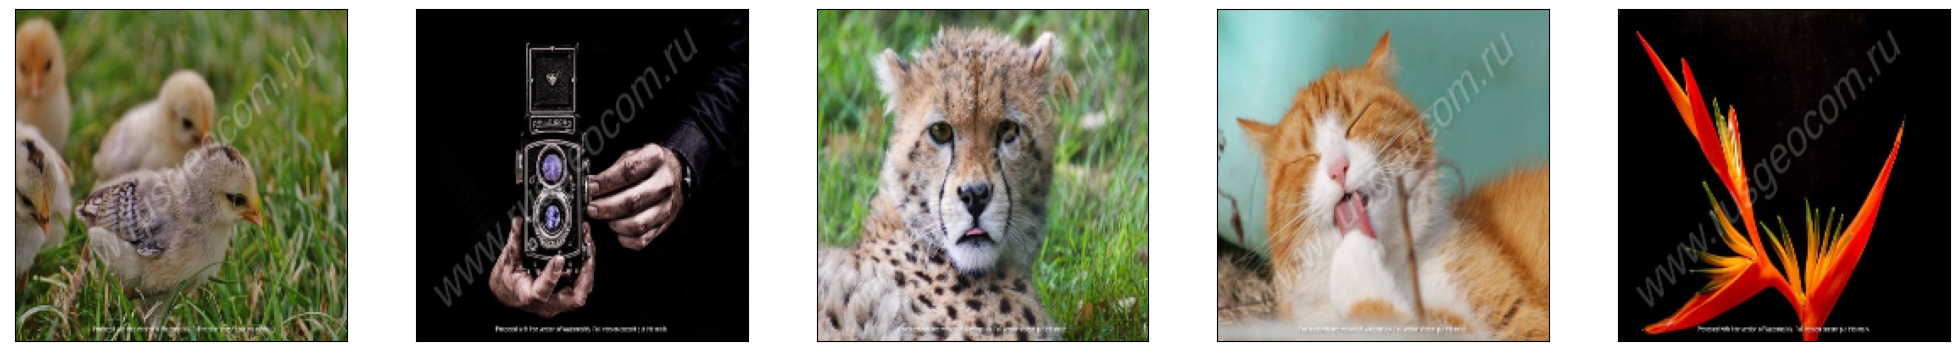

In [9]:
plt.figure(figsize=(25,25))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# Functions to data augment images 

def data_augmentation(inputImage): # run image through all augmentation methods
    return randomContrast(randomBrightness(inputImage)).numpy()
    # return randomCrop(randomFlip(inputImage)) # use augmentation methods without messing with colour 

def randomFlip(pic): # flips the image up and down before left and right at random
    return tf.image.random_flip_up_down(tf.image.random_flip_left_right(pic, 1), 1)

# def randomCrop(pic): # crops the image from a randomly defined width and height, that are under the intial image width and height
#     return tf.image.random_crop(pic, size=[random.randint(75,width), random.randint(75,height), 3], seed=None)

def randomBrightness(pic): # makes the image a random brightness from 1% to 20%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.2), 1)

def randomContrast(pic): # contrasts the image from 5% to 50%
    return tf.image.random_contrast(pic, 0.2, 0.7, 1)

2023-02-13 21:11:04.131811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-13 21:11:04.131837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aldar-LAPKC71E
2023-02-13 21:11:04.131841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aldar-LAPKC71E
2023-02-13 21:11:04.131979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.78.1
2023-02-13 21:11:04.131995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.78.01  Release Build  (dvs-builder@U16-J11-10-2)  Mon Dec 26 05:50:21 UTC 2022
GCC version:  gcc version 9.4.0 (Ubuntu 9.4.

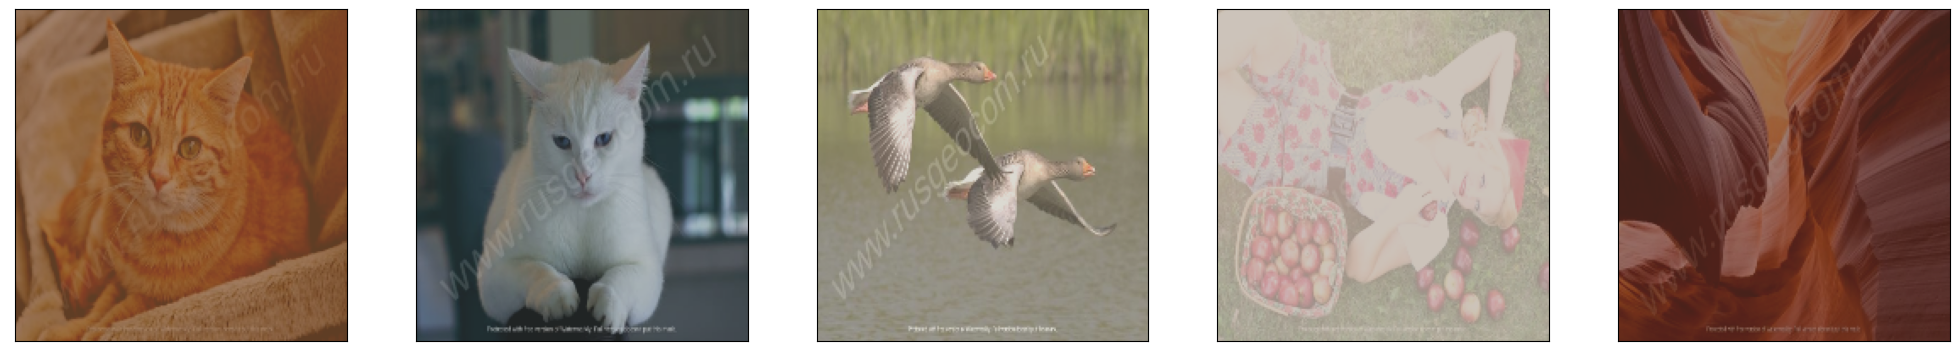

In [11]:
# Output Tensorflow data augmented images
plt.figure(figsize=(25,25))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    augmented_image = data_augmentation(X_train[random.randint(1, len(X_train))]) # send 25 images into data augmentation
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)) # not using cv2 as it messed up the code
plt.show()

In [12]:
#apply data augmentation to the X_train and y_train

data_augmented_X = [] 
data_augmented_y = []

for image in X_train:
    data_augmented_X.append(data_augmentation(image))
    
for image in y_train:
    data_augmented_y.append(data_augmentation(image))

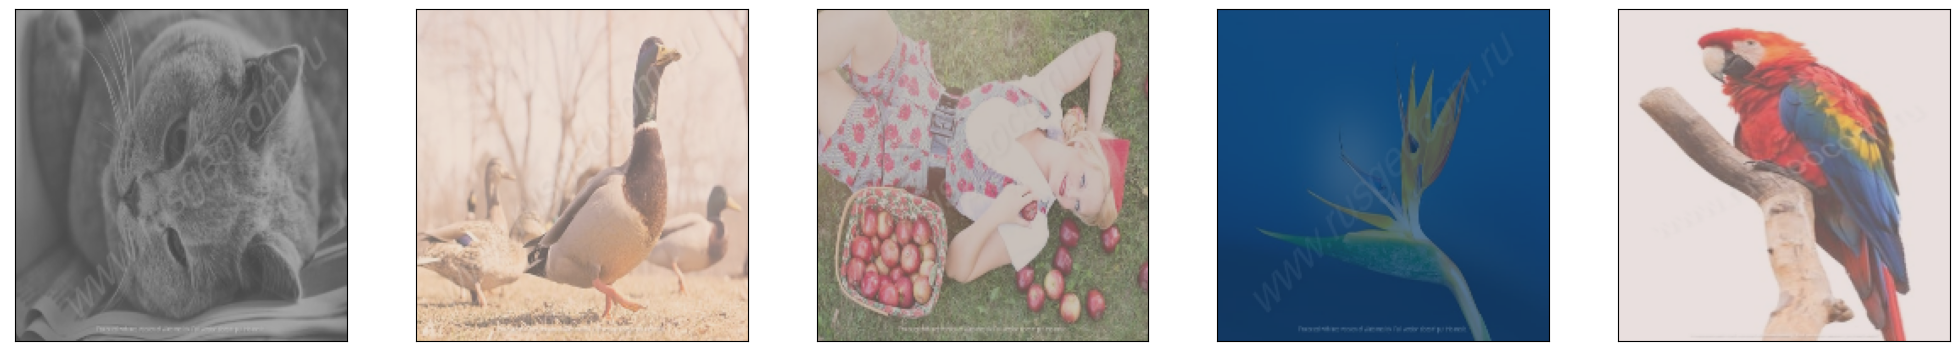

In [13]:
plt.figure(figsize=(25,25))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_X[i], cv2.COLOR_BGR2RGB))
plt.show()

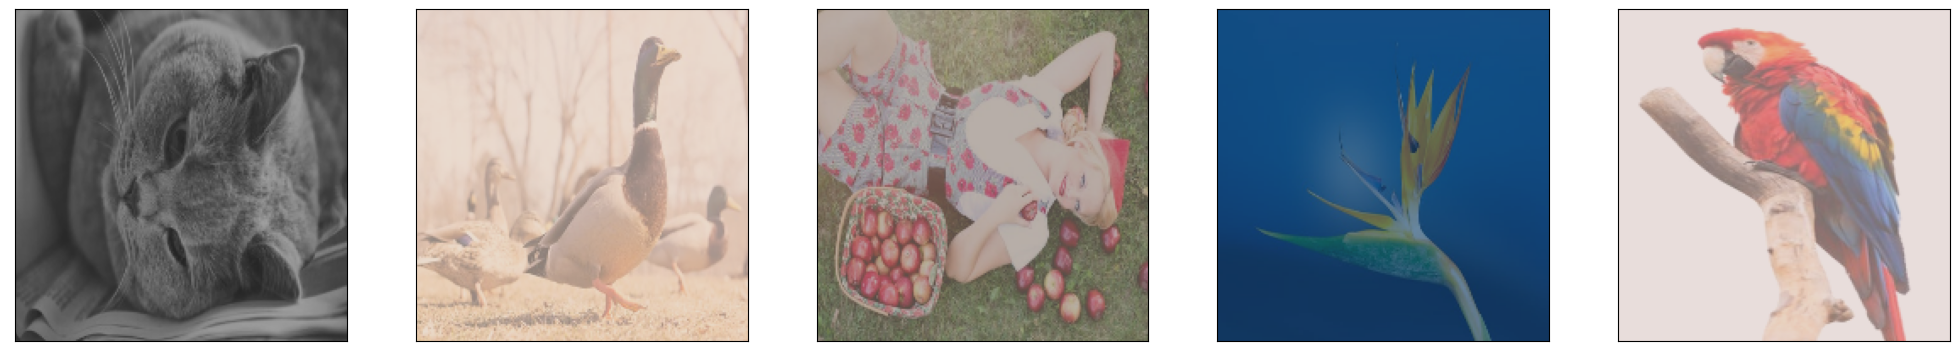

In [14]:
plt.figure(figsize=(25,25))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_y[i], cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

In [16]:
# normalize 
X_train = X_train / 255
y_train = y_train / 255
X_test = X_test / 255
y_test = y_test / 255

In [136]:
# base model for removing 

def create_model(img_x, img_y):
    x = Input(shape=(img_x, img_y, 3))
    
    # Think this process as function composition in algebra 
    
    # Encoder - compresses the input into a latent representation
    e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
    batchnorm_1 = BatchNormalization()(pool1)
    
    e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
    pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
    batchnorm_2 = BatchNormalization()(pool2)
    
    e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
    h = MaxPooling2D((2, 2), padding='same')(e_conv3)
    
    # Decoder - reconstructs the input from a latent representation 
    d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
    up1 = UpSampling2D((2, 2))(d_conv1)
    
    d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(d_conv2)
    
    d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2, 2))(d_conv3)
    
    r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    
    model = Model(x, r)
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mae')
    return model

In [137]:
watermark_auto_encoder = create_model(width, height)
#early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = watermark_auto_encoder.fit(X_train, y_train, batch_size=5, epochs=150)#, callbacks=[early_stop])

Epoch 1/150
21/21 [==============================] - 2s 72ms/step - loss: 0.1644
Epoch 2/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1399
Epoch 3/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1626
Epoch 4/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1398
Epoch 5/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1293
Epoch 6/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1417
Epoch 7/150
21/21 [==============================] - 1s 70ms/step - loss: 0.1401
Epoch 8/150
21/21 [==============================] - 1s 70ms/step - loss: 0.1284
Epoch 9/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1409
Epoch 10/150
21/21 [==============================] - 2s 72ms/step - loss: 0.1292
Epoch 11/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1227
Epoch 12/150
21/21 [==============================] - 2s 75ms/step - loss: 0.1252
Epoch 13/150
21/21 [=====

21/21 [==============================] - 1s 71ms/step - loss: 0.1032
Epoch 102/150
21/21 [==============================] - 1s 70ms/step - loss: 0.0993
Epoch 103/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1036
Epoch 104/150
21/21 [==============================] - 1s 70ms/step - loss: 0.1132
Epoch 105/150
21/21 [==============================] - 1s 70ms/step - loss: 0.1111
Epoch 106/150
21/21 [==============================] - 1s 70ms/step - loss: 0.1051
Epoch 107/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1048
Epoch 108/150
21/21 [==============================] - 1s 70ms/step - loss: 0.1004
Epoch 109/150
21/21 [==============================] - 1s 71ms/step - loss: 0.0980
Epoch 110/150
21/21 [==============================] - 1s 70ms/step - loss: 0.0976
Epoch 111/150
21/21 [==============================] - 1s 71ms/step - loss: 0.0986
Epoch 112/150
21/21 [==============================] - 1s 71ms/step - loss: 0.1021
Epoch 113/150
21/2

In [19]:
abc=watermark_auto_encoder.predict(X_test)
abc

1/1 [==============================] - 0s 142ms/step


array([[[[0.34886754, 0.3841571 , 0.26685613],
         [0.15890484, 0.3039646 , 0.32043192],
         [0.16387288, 0.30410665, 0.3350946 ],
         ...,
         [0.21253107, 0.43257812, 0.41814324],
         [0.21942194, 0.44154596, 0.433943  ],
         [0.25224814, 0.45307252, 0.4494601 ]],

        [[0.248015  , 0.32140067, 0.29990616],
         [0.16933809, 0.30354866, 0.2926215 ],
         [0.1700689 , 0.29915595, 0.29354244],
         ...,
         [0.18299717, 0.40689418, 0.4036608 ],
         [0.19803871, 0.4147286 , 0.41940957],
         [0.25160825, 0.42932323, 0.4268321 ]],

        [[0.22733866, 0.34739462, 0.32865596],
         [0.16702662, 0.32758364, 0.30534393],
         [0.16855353, 0.32895562, 0.31635123],
         ...,
         [0.17296082, 0.40642068, 0.37264863],
         [0.19233426, 0.41498765, 0.38596326],
         [0.25120643, 0.42586365, 0.41141054]],

        ...,

        [[0.14292707, 0.30871636, 0.2614261 ],
         [0.0876183 , 0.25428364, 0.21140242]

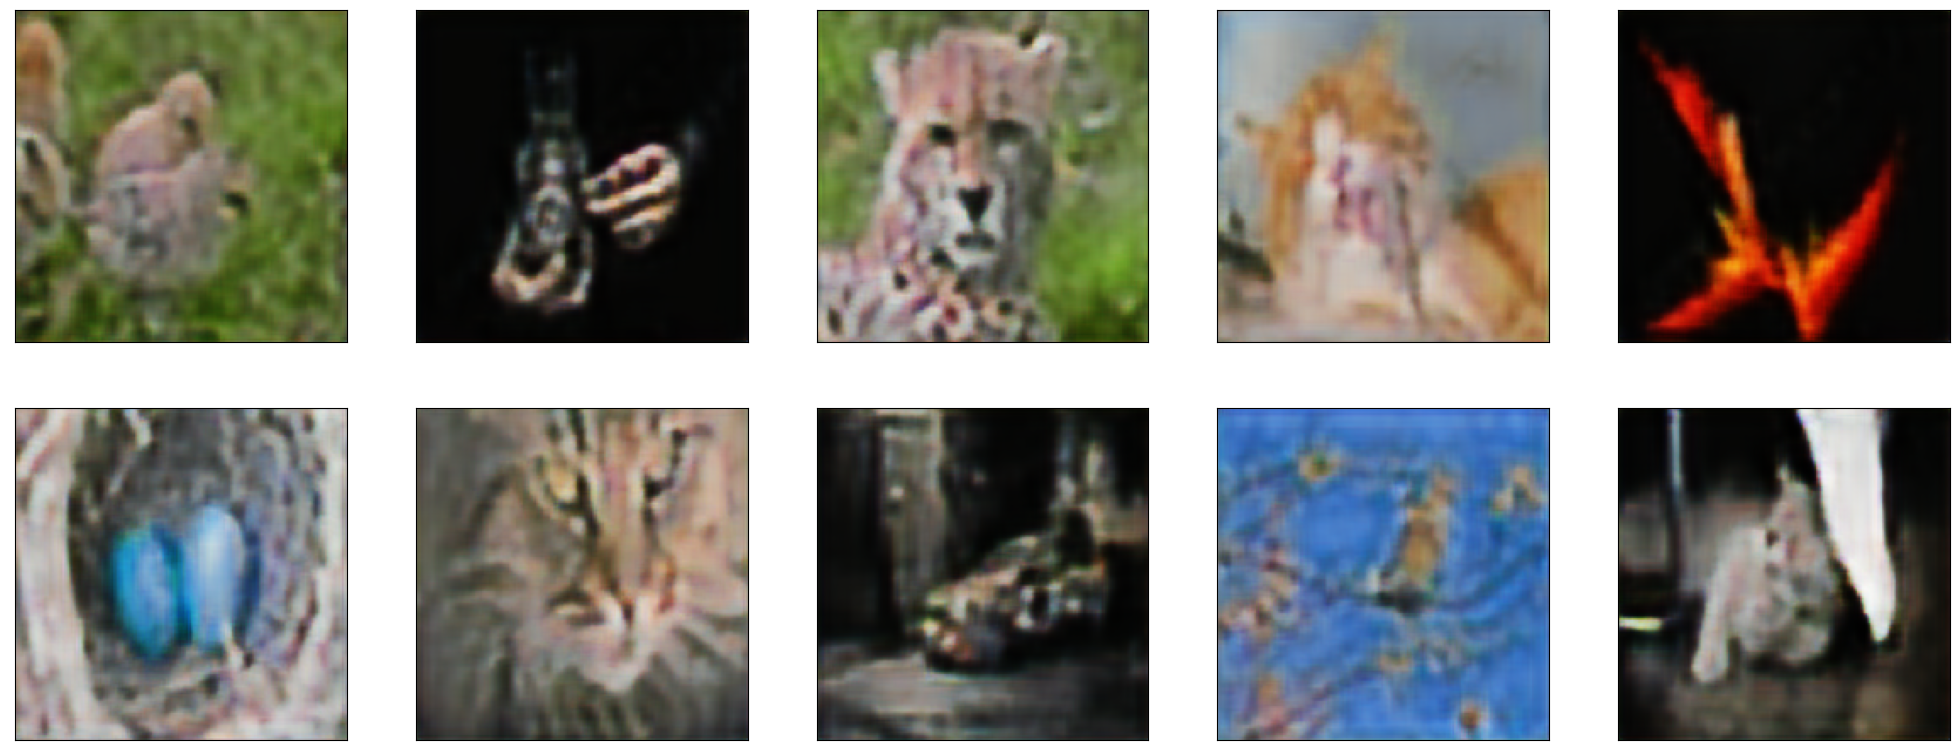

In [20]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(abc[i], cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
#watermark_auto_encoder.save("my_model1")

In [149]:
names=np.array(['image_dia/testing/'+x for x in os.listdir('image_dia/testing')])
precde=createPixelArr(names)
cde=np.array(precde / 255, dtype=np.float32)
xyz=watermark_auto_encoder.predict(cde)

1/1 [==============================] - 0s 209ms/step


# Было

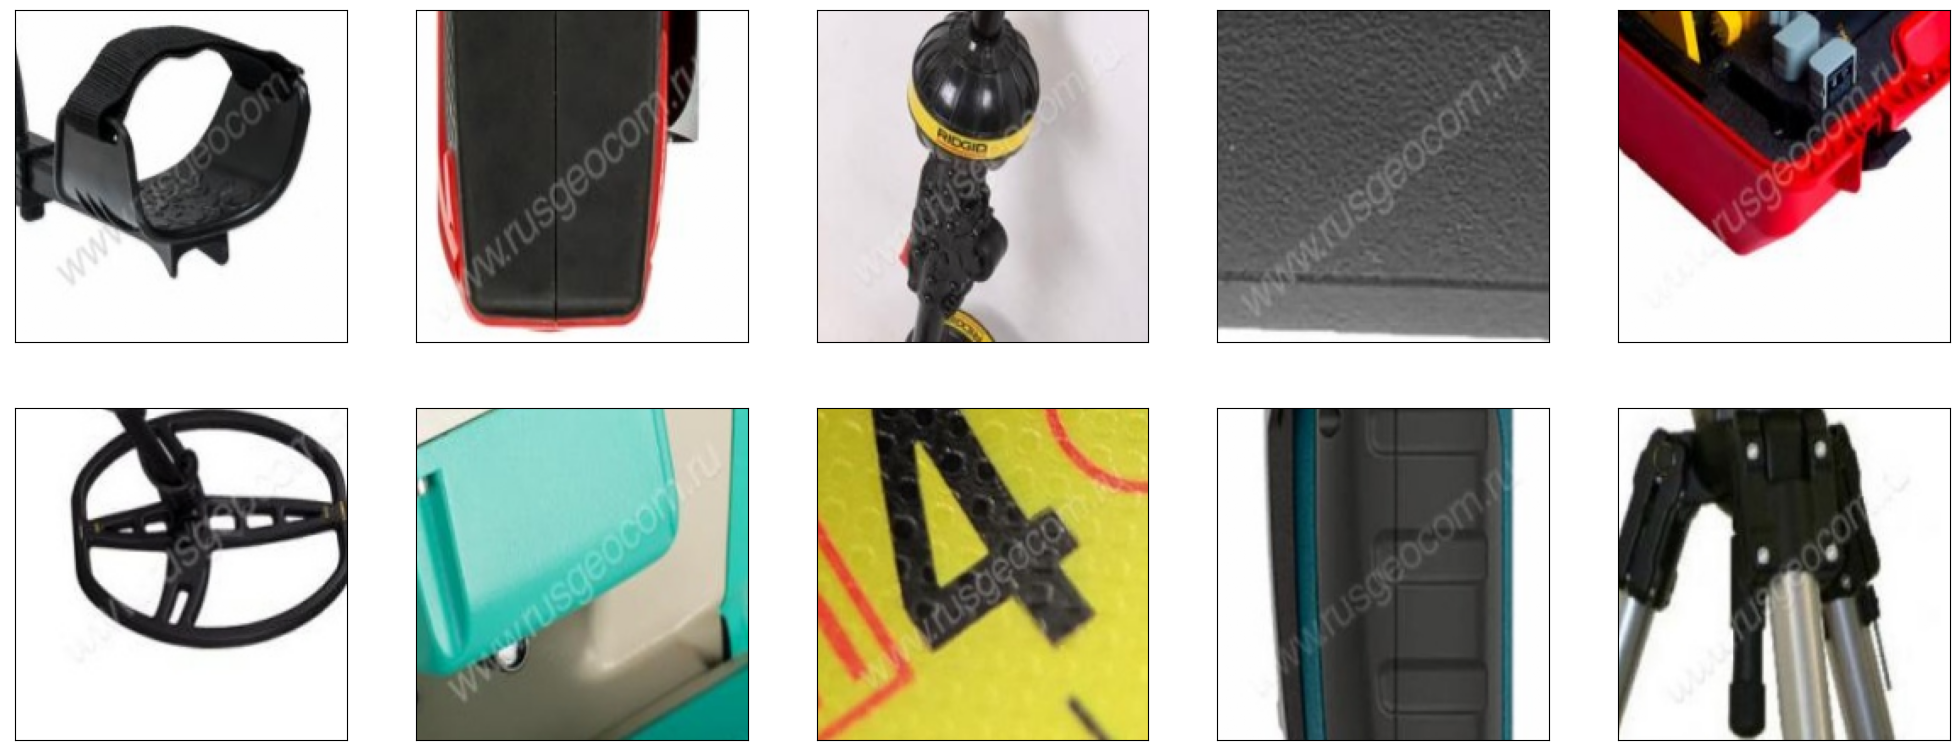

In [133]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(cde[i], cv2.COLOR_BGR2RGB))
plt.show()

In [142]:
cde.shape

(31, 196, 196, 3)

# Стало

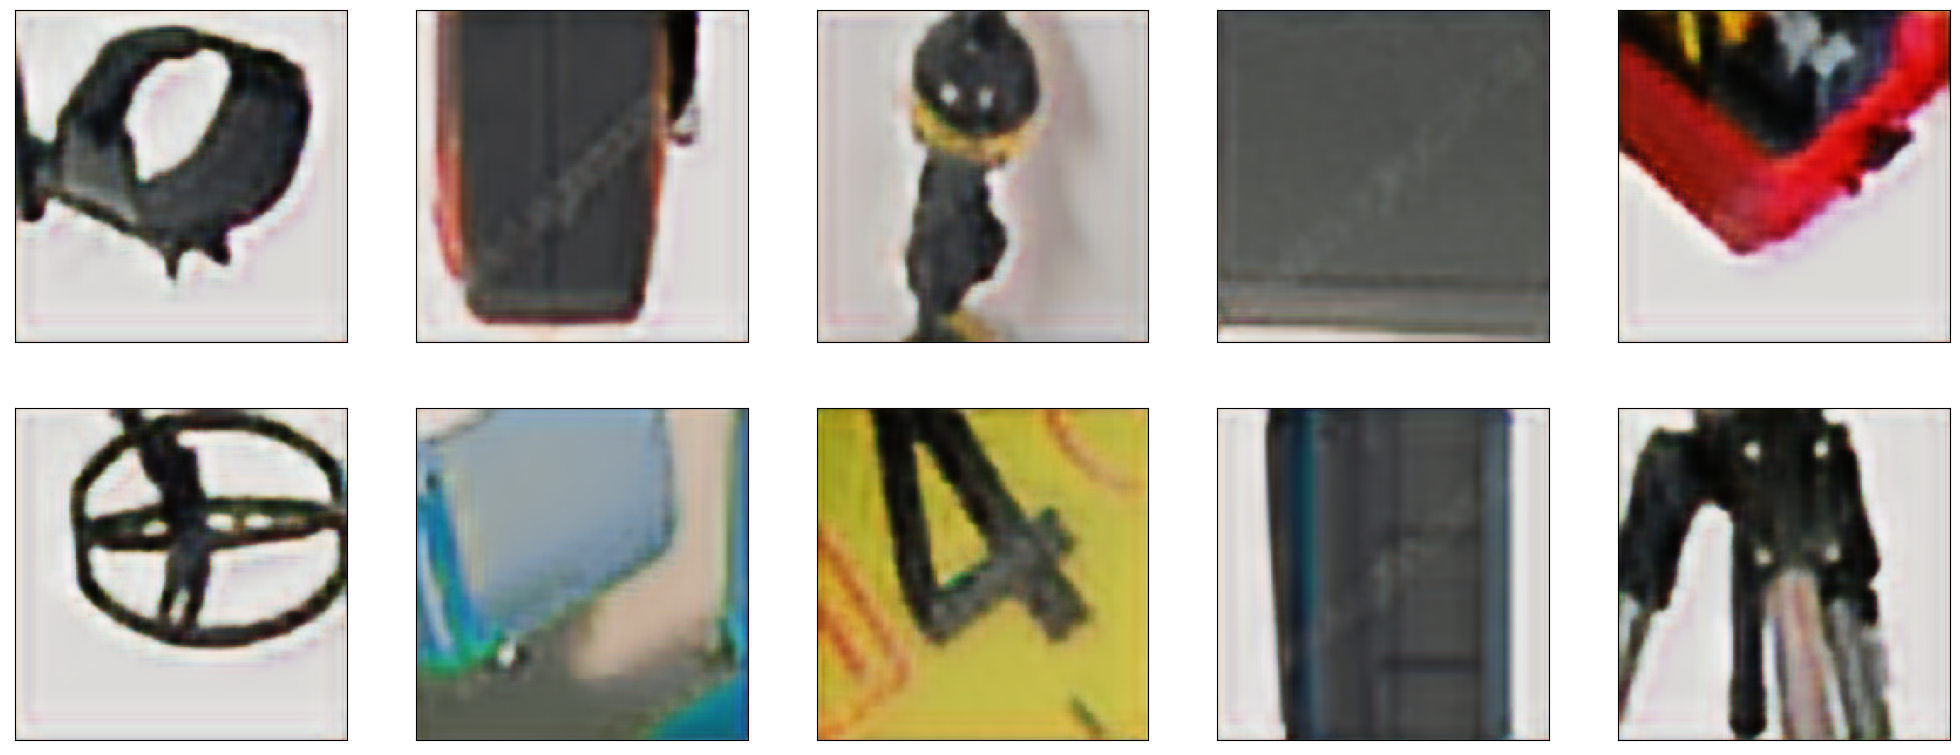

In [131]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(xyz[i], cv2.COLOR_BGR2RGB))
plt.show()

# Как заплатка

In [153]:
new_img=cde
for k in range(cde.shape[0]):
    for i in range(196):
        for j in range(196):
            if (i+j)>170 and (i+j)<230:
                if xyz[k][i][j][0]>cde[k][i][j][0] and xyz[k][i][j][1]>cde[k][i][j][1] and xyz[k][i][j][2]>cde[k][i][j][2]:
                    new_img[k][i][j]=xyz[k][i][j]

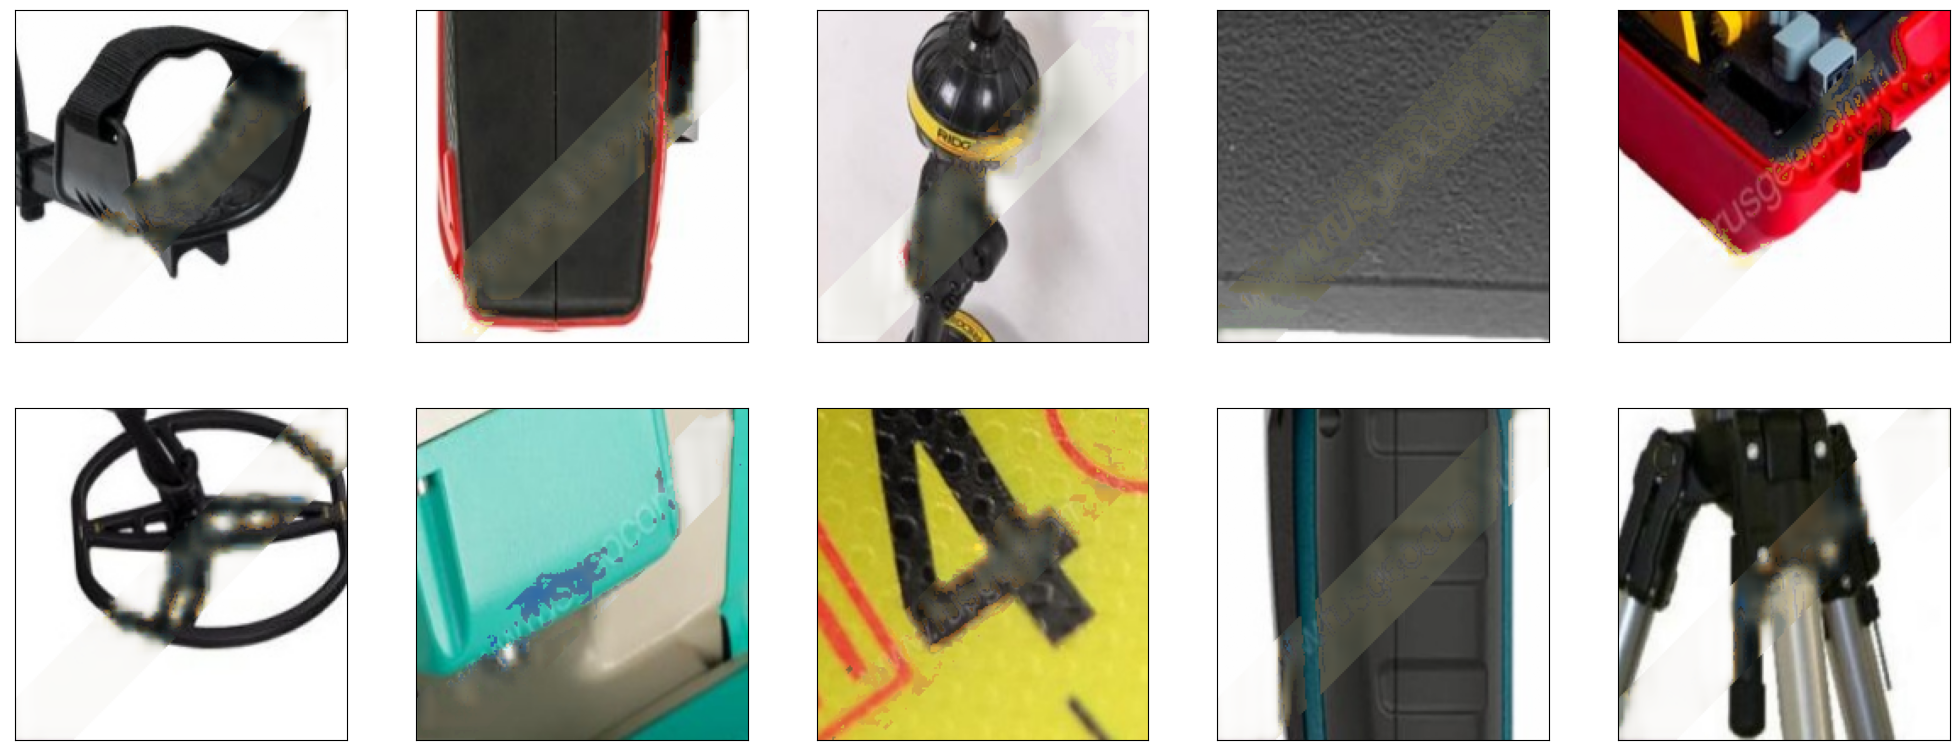

In [154]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(new_img[i], cv2.COLOR_BGR2RGB))
plt.show()